# The impact of grid and velocity interpolation scheme on trajectories

The notebook below shows how sensitive trajectories are to the combination of grid and velocity interpolation schemes. We will use the Peninsula example (also discussed in the [Quickstart to Parcels tutorial](https://docs.oceanparcels.org/en/latest/examples/parcels_tutorial.html#Sampling-a-Field-with-Particles)), and carefully compare how trajectories on the [A-grid and C-grid](https://docs.oceanparcels.org/en/latest/examples/documentation_indexing.html) version of this flow differ. To enhance the differences, we deliberately use a very coarse-resolution grid.

In [1]:
from dataclasses import dataclass
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import scipy
import xarray as xr
from matplotlib.lines import Line2D

import parcels

We start with defining the `FieldSet` for the Peninsula flow and the grid. Note that on the A-grid we can directly calculate the velocities on the grid points from the streamfunction `P`. On the C-grid, we need to differentiate the streamfunction `P` to get the velocities on the staggered `U` and `V` grid points.

In [2]:
def peninsula_fieldset(xdim=14, ydim=16, grid_type="A", interp_method="linear"):
    domainsizeX, domainsizeY = (1.0e5, 5.0e4)
    lon = np.linspace(0, domainsizeX, xdim, dtype=np.float32)
    lat = np.linspace(0, domainsizeY, ydim, dtype=np.float32)

    u0 = 1
    x0 = domainsizeX / 2
    R = 0.32 * domainsizeX / 2

    x, y = np.meshgrid(lon, lat, sparse=True, indexing="xy")
    P = u0 * R**2 * y / ((x - x0) ** 2 + y**2) - u0 * y
    landpoints = P >= 0.0
    P[landpoints] = 0.0

    if grid_type == "A":
        U = u0 - u0 * R**2 * ((x - x0) ** 2 - y**2) / (((x - x0) ** 2 + y**2) ** 2)
        V = -2 * u0 * R**2 * ((x - x0) * y) / (((x - x0) ** 2 + y**2) ** 2)
        U[landpoints] = 0.0
        V[landpoints] = 0.0
    elif grid_type == "C":
        U = np.zeros(P.shape)
        V = np.zeros(P.shape)
        V[:, 1:] = (P[:, 1:] - P[:, :-1]) / (lon[1] - lon[0])
        U[1:, :] = -(P[1:, :] - P[:-1, :]) / (lat[1] - lat[0])

    data = {"U": U, "V": V, "P": P}
    dimensions = {"lon": lon, "lat": lat}

    fieldset = parcels.FieldSet.from_data(data, dimensions, mesh="flat")
    fieldset.U.interp_method = interp_method
    fieldset.V.interp_method = interp_method
    return fieldset

Next, we define some helper Kernels and the ParticleType.

In [3]:
def SampleP(particle, fieldset, time):
    particle.p = fieldset.P[time, particle.lon, particle.lat, particle.depth]


def DeleteParticle(particle, fieldset, time):
    if particle.state >= 50:
        particle.delete()


ptype = parcels.Particle.add_variables({"p": np.float32})

Now we run six different experiments, each with a different combination of grid type ("A" or "C") and velocity interpolation scheme (["linear"](https://docs.oceanparcels.org/en/latest/examples/tutorial_interpolation.html), ["freeslip"](https://docs.oceanparcels.org/en/latest/examples/documentation_unstuck_Agrid.html#3.-Slip-boundary-conditions), ["cgrid_velocity"](https://docs.oceanparcels.org/en/latest/examples/documentation_indexing.html) and ["analytical"](https://docs.oceanparcels.org/en/latest/examples/tutorial_analyticaladvection.html)).

In [4]:
@dataclass
class Experiment:
    """Utility class to consolidate experiment parameters."""

    grid_type: Literal["A", "C"]
    interp_method: Literal["linear", "freeslip", "cgrid_velocity", "analytical"]

    @property
    def fieldset_interp_method(self):
        """Which FieldSet interpolation method to use for each experiment."""
        if self.interp_method == "analytical":
            return "cgrid_velocity"
        return self.interp_method

    @property
    def advection_kernel(self):
        if self.interp_method == "analytical":
            return parcels.AdvectionAnalytical
        return parcels.AdvectionRK4

    @property
    def file_name(self):
        return f"Trajs_{self.grid_type}_{self.interp_method}.zarr"

    @property
    def plot_title(self):
        if self.interp_method == "analytical":
            interp_name = "analytical advection"
        else:
            interp_name = f"{self.interp_method.replace('_velocity', '')} interpolation"
        return f"{self.grid_type}grid & {interp_name}"


exps = [
    Experiment("A", "linear"),
    Experiment("A", "freeslip"),
    Experiment("C", "cgrid_velocity"),
    Experiment("C", "analytical"),
    Experiment("A", "cgrid_velocity"),
    Experiment("C", "linear"),
]

dt = 1e3  # setting output and execution timestep to same value

for exp in exps:
    fieldset = peninsula_fieldset(
        grid_type=exp.grid_type, interp_method=exp.fieldset_interp_method
    )

    pset = parcels.ParticleSet.from_line(
        fieldset, pclass=ptype, size=7, start=(1e3, 1e3), finish=(1e3, 10e3)
    )
    outfile = pset.ParticleFile(name=exp.file_name, outputdt=dt)

    pset.execute(
        [exp.advection_kernel, SampleP, DeleteParticle],
        endtime=1e5,
        dt=dt,
        output_file=outfile,
    )

INFO: Output files are stored in Trajs_A_linear.zarr.
100%|██████████| 100000.0/100000.0 [00:05<00:00, 19241.54it/s]
INFO: Output files are stored in Trajs_A_freeslip.zarr.
100%|██████████| 100000.0/100000.0 [00:05<00:00, 19214.29it/s]
INFO: Output files are stored in Trajs_C_cgrid_velocity.zarr.
100%|██████████| 100000.0/100000.0 [00:04<00:00, 22020.46it/s]
INFO: Output files are stored in Trajs_C_analytical.zarr.
100%|██████████| 100000.0/100000.0 [00:04<00:00, 20195.86it/s]
INFO: Output files are stored in Trajs_A_cgrid_velocity.zarr.
100%|██████████| 100000.0/100000.0 [00:04<00:00, 20515.74it/s]
INFO: Output files are stored in Trajs_C_linear.zarr.
100%|██████████| 100000.0/100000.0 [00:04<00:00, 22079.42it/s]


We carefully compute the landmask (i.e. where the peninsula field has land), which is important for the interpretation of land that is consistent with Parcels (see also the [Preventing stuck particles tutorial](https://docs.oceanparcels.org/en/latest/examples/documentation_unstuck_Agrid.html#2.-Displacement)).

In [5]:
landmask = np.ma.masked_values(fieldset.U.data[0, :, :], 0)
landmask = landmask.mask.astype("int")

lonplot, latplot = np.meshgrid(fieldset.U.lon, fieldset.U.lat)

fl = scipy.interpolate.RectBivariateSpline(
    fieldset.U.lat, fieldset.U.lon, landmask, kx=1, ky=1
)
x = fieldset.U.lon[:-1] + np.diff(fieldset.U.lon) / 2
y = fieldset.U.lat[:-1] + np.diff(fieldset.U.lat) / 2
lon_centers, lat_centers = np.meshgrid(x, y)
l_centers = fl(lat_centers[:, 0], lon_centers[0, :])
lmask = np.ma.masked_values(l_centers, 1)

Finally, we plot the trajectories for all six experiments. We see that the trajectories are very sensitive to the combination of grid and velocity interpolation scheme. Note for example that using `cgrid_velocity` interpolation on an A-grid (fifth panel) leads to particles getting grounded on the land, which is not physical.

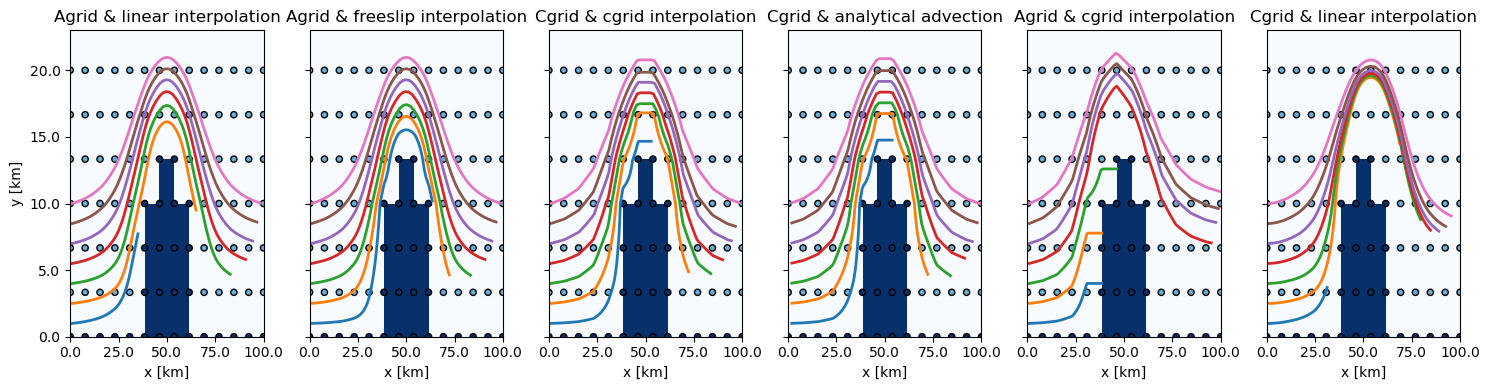

In [6]:
fig, axs = plt.subplots(1, len(exps), figsize=(15, 4), sharey="row")


def plot_experiment(ax, exp: Experiment) -> None:
    ds = xr.open_zarr(exp.file_name)
    ax.pcolormesh(lonplot, latplot, lmask.mask, cmap="Blues")
    ax.scatter(
        lonplot,
        latplot,
        c=landmask,
        s=20,
        cmap="Blues",
        vmin=-0.05,
        vmax=0.05,
        edgecolors="k",
    )
    ax.plot(ds["lon"].T, ds["lat"].T, linewidth=2)
    ax.set_title(exp.plot_title)

    # Set the same limits for all subplots
    ax.set_xlim([fieldset.U.lon.min(), fieldset.U.lon.max()])
    ax.set_ylim([0, 23e3])
    m2km = lambda x, _: f"{x/1000:.1f}"
    ax.xaxis.set_major_formatter(m2km)
    ax.yaxis.set_major_formatter(m2km)
    ax.set_xlabel("x [km]")


for i, (ax, exp) in enumerate(zip(axs, exps)):
    if i == 0:
        ax.set_ylabel("y [km]")
    plot_experiment(ax, exp)

plt.tight_layout()
plt.show()

Because we know that particles must follow lines of constant streamfunction, we can also plot the streamlines of the flow field. When we overlay the "Agrid & linear interpolation" and "Cgrid & cgrid interpolation" trajectories onto these streamlines, we see that they are subtly different.

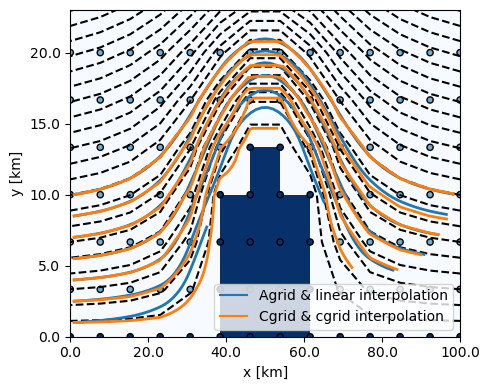

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.pcolormesh(lonplot, latplot, lmask.mask, cmap="Blues")
ax.scatter(
    lonplot,
    latplot,
    c=landmask,
    s=20,
    cmap="Blues",
    vmin=-0.05,
    vmax=0.05,
    edgecolors="k",
)
ax.contour(lonplot, latplot, fieldset.P.data[0, :, :], colors="k", levels=50)

exps_of_interest = filter(
    lambda exp: exp.plot_title
    in ["Agrid & linear interpolation", "Cgrid & cgrid interpolation"],
    exps,
)
handles = []
for i, exp in enumerate(exps_of_interest):
    ds = xr.open_zarr(exp.file_name)
    ax.plot(
        ds["lon"].T,
        ds["lat"].T,
        linewidth=2,
        color=f"C{i:02d}",
    )
    # Manually save label for legend
    handles.append(Line2D([0], [0], label=exp.plot_title, color=f"C{i:02d}"))

ax.legend(handles=handles)
ax.set_xlim([fieldset.U.lon.min(), fieldset.U.lon.max()])
ax.set_ylim([0, 23e3])
ax.set_ylabel("y [km]")
ax.set_xlabel("x [km]")
m2km = lambda x, _: f"{x/1000:.1f}"
ax.xaxis.set_major_formatter(m2km)
ax.yaxis.set_major_formatter(m2km)

plt.tight_layout()
plt.show()

To further investigate the differences, we can also plot the change in the streamfunction value sampled by the particle (`particle.p`) between the final and start location for each experiment. We see that the difference is larger for particles that start farther south and thus get closer to the peninsula. The difference in streamfunction change for the particle that started farthest north is very close to zero for all of the first four experiments; and much larger for the fifth and sixth experiments (where the grid and interpolation scheme do not match up). 

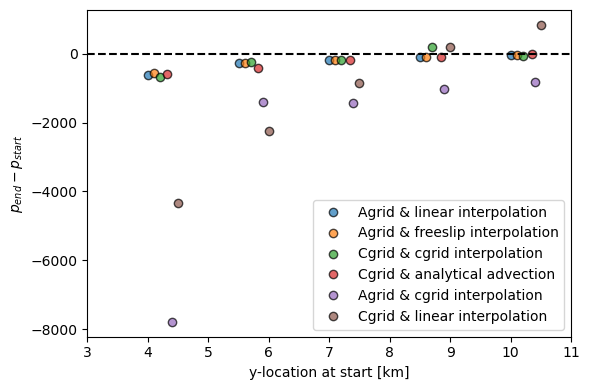

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

for i, exp in enumerate(exps):
    ds = xr.open_zarr(exp.file_name)
    ax.plot(
        ds.lat[2:, 0] / 1e3 + i / 10,
        ds.p[2:, -1] - ds.p[2:, 0],
        "o",
        alpha=0.7,
        label=exp.plot_title,
        markeredgecolor="k",
    )
ax.legend(loc="lower right")
ax.hlines(0, 3, 11, linestyles="--", color="k")
ax.set_xlabel("y-location at start [km]")
ax.set_xlim([3, 11])
ax.set_ylabel("$p_{end} - p_{start}$")
plt.tight_layout()
plt.show()

This clearly shows why it is important to consider the combination of grid and interpolation scheme when running Parcels simulations.